<a href="https://www.kaggle.com/code/mmellinger66/ps3e5-wine-quality-models?scriptVersionId=119089725" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 <div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Playground Season 3: Episode 5 - Wine Quality</h1>
</div>

## Problem Type

Multi-class Classification

## Evaluation Metric


<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [1]:
from typing import List, Set, Dict, Tuple, Optional

import os
import time
from pathlib import Path
import glob
import gc

import pandas as pd
import numpy as np

from sklearn import impute
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import cluster
from sklearn import decomposition
from sklearn import model_selection
from sklearn import ensemble
from sklearn import datasets

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from folium import Map
from folium.plugins import HeatMap
from IPython.display import display_html, display_markdown, display_latex
from colorama import Fore, Style

import warnings
warnings.filterwarnings('ignore')

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
TARGET="quality"

In [3]:
class Config:
    path:str = "../input/playground-series-s3e5/"
    gpu:bool = False
    optimize:bool = False
    n_optuna_trials:int = 5
    fast_render:bool = False
    calc_probability:bool = False
    debug:bool = False
    seed:int = 42
    N_ESTIMATORS:int = 5000  # 100, 300, 1000, 2000, 5000, 15_000, 20_000 GBDT
    GPU_N_ESTIMATORS:int = 1000 # Want models to run fast during dev
    N_FOLDS:int = 5

In [4]:
class clr:
    S = Style.BRIGHT + Fore.LIGHTRED_EX
    E = Style.RESET_ALL

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

In [5]:
def read_data(path: str, analyze:bool=True) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print(clr.S + "=== Shape of Data ==="+clr.E)
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print(clr.S + "\n=== Train Data: First 5 Rows ===\n"+clr.E)
        display(train.head())
        print(f"\n{clr.S}=== Train Column Names ==={clr.E}\n")
        display(train.columns)
        print(f"\n{clr.S}=== Features/Explanatory Variables ==={clr.E}\n")
        eval_features(train)
        print(f"\n{clr.S}=== Skewness ==={clr.E}\n")
        check_skew(train)
    return train, test, submission_df

def create_submission(model_name: str, target, preds, seed:int=42, nfolds:int=5) -> pd.DataFrame:
    sample_submission[target] = preds.astype(int)

    if len(model_name) > 0:
        fname = f"submission_{model_name}_k{nfolds}_s{seed}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission

def show_classification_scores(ground_truth:List[int], yhat:List[int]) -> None:
    accuracy = metrics.accuracy_score(ground_truth, yhat)
    precision = metrics.precision_score(ground_truth, yhat)
    recall = metrics.recall_score(ground_truth, yhat)
    roc = metrics.roc_auc_score(ground_truth, yhat)
    f1 = metrics.f1_score(ground_truth, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC: {roc:.4f}")
    print(f"f1: {f1:.4f}")
    

def label_encoder(train:pd.DataFrame, test:pd.DataFrame, columns:List[str]) -> (pd.DataFrame, pd.DataFrame) :
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = preprocessing.LabelEncoder().fit_transform(train[col])
        test[col] = preprocessing.LabelEncoder().fit_transform(test[col])
    return train, test   

def create_strat_folds(df:pd.DataFrame, TARGET, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


def create_folds(df:pd.DataFrame, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

def show_fold_scores(scores: List[float]) -> (float, float):
    cv_score = np.mean(scores)  # Used in filename
    std_dev = np.std(scores)
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )
    return cv_score, std_dev


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(df.select_dtypes(include=['int64', 'float64', 'uint8']).columns)
    categorical_features = list(df.select_dtypes(include=['object', 'bool']).columns)
    if display:
        print(f"{clr.S}Continuous Features={continuous_features}{clr.E}\n")
        print(f"{clr.S}Categorical Features={categorical_features}{clr.E}")
    return continuous_features, categorical_features   

def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print("=== Cardinality ===")
    print(df[features].nunique())

## === Model Support ===    

from scipy.stats import mode


def merge_test_predictions(final_test_predictions:List[float], calc_probability:bool=True) -> List[float]:

    if calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result

def summary_statistics(X:pd.DataFrame, enhanced=True) -> None:
    desc = X.describe()
    if enhanced:
        desc.loc["var"] = X.var(numeric_only=True).tolist()
        desc.loc["skew"] = X.skew(numeric_only=True).tolist()
        desc.loc["kurt"] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context("display.precision", 2):
        style = desc.transpose().style.background_gradient(
            cmap="coolwarm"
        )  # .set_precision(4)
    display(style)
    
def show_missing_features(df:pd.DataFrame) -> None:
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])


def show_duplicate_records(df:pd.DataFrame) -> None:
    dups = df.duplicated()
    print(dups.sum())


def eval_features(df:pd.DataFrame) -> (List[str], List[str], List[str]):
    ## Separate Categorical and Numerical Features
    categorical_features = list(
        df.select_dtypes(include=["category", "object"]).columns
    )
    continuous_features = list(df.select_dtypes(include=["number"]).columns)

    print(f"{clr.S}Continuous features:{clr.E} {continuous_features}")
    print(f"{clr.S}Categorical features:{clr.E} {categorical_features}")
    print("\n --- Cardinality of Categorical Features ---\n")

    for feature in categorical_features:
        cardinality = df[feature].nunique()
        if cardinality < 10:
            print(f"{clr.S}{feature}{clr.E}: cardinality={cardinality}, {df[feature].unique()}")
        else:
            print(f"{clr.S}{feature}{clr.E}: cardinality={cardinality}")
    all_features = categorical_features + continuous_features
    return all_features, categorical_features, continuous_features


def show_feature_importance(feature_importance_lst:List[str]) -> None:
    fis_df = pd.concat(feature_importance_lst, axis=1)

    fis_df.sort_values("0_importance", ascending=True).head(40).plot(
        kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
    )
    plt.show()


def show_feature_target_crosstab(df:pd.DataFrame, feature_lst:List[str], target:str) -> None:
    for feature in feature_lst:
        print(f"\n=== {feature} vs {target} ===\n")
        display(
            pd.crosstab(df[feature], df[target], margins=True)
        )  # display keeps bold formatting


def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print(f"{clr.S}=== Cardinality ==={clr.E}")
    print(df[features].nunique())


def show_unique_features(df:pd.DataFrame, features:List[str]) -> None:
    for col in features:
        print(col, sorted(df[col].dropna().unique()))


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(
        df.select_dtypes(include=["int64", "float64", "uint8"]).columns
    )
    categorical_features = list(df.select_dtypes(include=["object", "bool"]).columns)
    if display:
        print(f"{clr.S}Continuous Features={clr.E}{continuous_features}\n")
        print(f"{clr.S}Categorical Features={clr.E}{categorical_features}")
    return continuous_features, categorical_features


def describe(X:pd.DataFrame) -> None:
    "Deprecated: Use summary_statistics()"
    desc = X.describe()
    desc.loc['var'] = X.var(numeric_only=True).tolist()
    desc.loc['skew'] = X.skew(numeric_only=True).tolist()
    desc.loc['kurt'] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context('display.precision', 2):
        style = desc.transpose().style.background_gradient(cmap='coolwarm') #.set_precision(4)
    display(style)
  

def check_skew(df:pd.DataFrame) -> None:
    skew = df.skew(skipna=True,numeric_only=True).sort_values(ascending=False)
    print(skew)
    
def gpu_ify_lgbm(lgbm_dict):
    lgbm_dict["device"] = "gpu"
    lgbm_dict["boosting_type"] = "gbdt"
    lgbm_dict["gpu_platform_id"] = 0
    lgbm_dict["gpu_device_id"] = 0
    return lgbm_dict

def gpu_ify_cb(params):
    params["task_type"] = "GPU"
    return params    


<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Optuna Hyperparameter Optimization Library</h1>
</div>

In [6]:
def objective_xgb(trial, X_train, X_valid, y_train, y_valid):

    xgb_params = {
        #         "objective": trial.suggest_categorical("objective", ["multi:softmax"]),
        #         "eval_metric": "mlogloss",
        #         "objective": "multi:softmax",
        "eval_metric": "auc",  # auc, rmse, mae
        "objective": "binary:logistic",
        #         "enable_categorical": trial.suggest_categorical("use_label_encoder", [True]),
        "use_label_encoder": trial.suggest_categorical("use_label_encoder", [False]),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 1, 20),  # 10
        "gamma": trial.suggest_float("gamma", 0, 100, step=0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "tree_method": trial.suggest_categorical(
            "tree_method", ["hist"]
        ),  # hist, gpu_hist
#         "predictor": "gpu_predictor",
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }

    # Model loading and training
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=5000,
        verbose=0,
    )

    print(f"Number of boosting rounds: {model.best_iteration}")
    #     oof = model.predict_proba(X_valid)[:, 1] # Probability
    oof = model.predict(X_valid)  # Classification: 0,1

    return metrics.accuracy_score(y_valid, oof)


def objective_lgbm(trial, X_train, X_valid, y_train, y_valid):

    params = {
        "boosting_type": "gbdt",
        # "objective": trial.suggest_categorical("objective", ["mae", "rmse"]),
        #         "objective": trial.suggest_categorical("objective", ["multi:softprob"]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [1_000]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [5000]),
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "importance_type": "gain",
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        #         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }
    if Config.gpu:
        params["device_type"] = "gpu"

    # Model loading and training
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # eval_metric="mae",
        callbacks=[
            lgb.log_evaluation(500),
            lgb.early_stopping(500, False, True),
        ],
    )

    #     print(f"Number of boosting rounds: {model.best_iteration}")
    oof = model.predict(X_valid)

    #     return accuracy_score(y_valid, oof)
    return metrics.roc_auc_score(y_valid, oof)

def objective_cb(trial, X_train, X_valid, y_train, y_valid):

    cb_params = {
        "iterations": 10,  # 1000
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.1, 1.0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 100),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.1, 20.0
        ),
        "random_strength": trial.suggest_float("random_strength", 1.0, 2.0),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "use_best_model": True,
        #         "task_type": "GPU",
        "random_seed": 42,
    }

    # Model loading and training
    model = cb.CatBoostClassifier(**cb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # eval_metric="accuracy",
        early_stopping_rounds=500,
        verbose=False,
    )

    # print(f"Number of boosting rounds: {model.best_iteration}")
    # oof = model.predict_proba(X_valid)[:, 1]
    oof = model.predict(X_valid)  # Classification

    return metrics.accuracy_score(y_valid, oof)

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data and Analyze</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the target variable
 - sample_submission.csv - A file in the proper format to submit test predictions

In [7]:
%%time
train, test, sample_submission = read_data(Config.path, analyze=True)                                

=== Shape of Data ===
 train data: Rows=2056, Columns=13
 test data : Rows=1372, Columns=12

=== Train Data: First 5 Rows ===



,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6



=== Train Column Names ===



Index(['Id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


=== Features/Explanatory Variables ===

Continuous features: ['Id', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Categorical features: []

 --- Cardinality of Categorical Features ---


=== Skewness ===

chlorides               5.262627
residual sugar          3.756802
sulphates               1.802854
total sulfur dioxide    1.267906
fixed acidity           0.959832
alcohol                 0.786872
free sulfur dioxide     0.681219
volatile acidity        0.668343
quality                 0.266307
citric acid             0.246571
pH                      0.216976
density                 0.202606
Id                      0.000000
dtype: float64
CPU times: user 29.3 ms, sys: 7.61 ms, total: 36.9 ms
Wall time: 63 ms


In [8]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


<AxesSubplot:xlabel='quality', ylabel='count'>

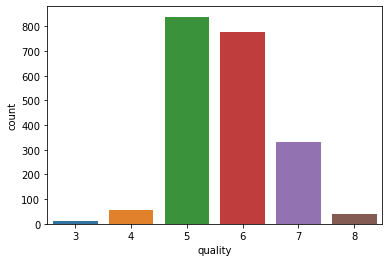

In [9]:
sns.countplot(data=train, x=TARGET)

In [10]:
original = pd.read_csv("../input/wine-quality-dataset/WineQT.csv")
original.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [11]:
train['origin']    = 0
test['origin']     = 0
original['origin'] = 1
combined = pd.concat([train, original], ignore_index=True)
train = combined

In [12]:
dup_idx = list(train.loc[train.duplicated(keep = "first")].index)
train = train.drop(index = dup_idx)
print("Number of duplicates:", len(dup_idx))
print("Non-duplicate rows:", train.shape[0] - original.shape[0])

Number of duplicates: 0
Non-duplicate rows: 2056


In [13]:
combined.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,origin
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6,0
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6,0
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7,0
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5,0
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6,0


In [14]:
# train[TARGET] = train[TARGET] - 3

In [15]:
summary_statistics(train.drop(columns=["Id"], axis=1), enhanced=True)

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
fixed acidity,3199.00,8.35,1.72,4.60,7.10,7.90,9.10,15.90,2.96,0.99,0.98
volatile acidity,3199.00,0.53,0.18,0.12,0.39,0.52,0.64,1.58,0.03,0.67,1.30
citric acid,3199.00,0.27,0.19,0.00,0.09,0.25,0.42,1.00,0.04,0.30,-0.82
residual sugar,3199.00,2.45,1.07,0.90,1.90,2.20,2.60,15.50,1.13,4.56,34.37
chlorides,3199.00,0.08,0.03,0.01,0.07,0.08,0.09,0.61,0.00,6.99,73.48
free sulfur dioxide,3199.00,16.48,10.12,1.00,7.00,15.00,23.00,68.00,102.32,0.88,0.79
total sulfur dioxide,3199.00,48.05,32.93,6.00,22.00,42.00,64.00,289.00,1084.43,1.40,3.56
density,3199.00,1.00,0.00,0.99,1.00,1.00,1.00,1.00,0.00,0.16,0.87
pH,3199.00,3.31,0.15,2.74,3.20,3.31,3.39,4.01,0.02,0.22,0.45
sulphates,3199.00,0.65,0.15,0.33,0.55,0.62,0.72,2.00,0.02,2.22,11.46


<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

## Categorical/Numerical Variables

In [16]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features.remove(TARGET)
cont_features.remove("Id")
FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['Id', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'origin']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'origin']

In [17]:
# https://www.kaggle.com/code/usedpython/s3e5-0-599-xgb-lgb-lg

def add_features(df):
    df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
    df['acid/density'] = df['total_acid']  / df['density']
    df['alcohol_density'] = df['alcohol']  * df['density']
    df['sulphate/density'] = df['sulphates']  / df['density']
    df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
    df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
    df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']
    return df

train = add_features(train)
test = add_features(test)

In [18]:
excluded_features = [TARGET, "Id", "fold"]

cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features = [feature for feature in cont_features if feature not in excluded_features]
cat_features = [feature for feature in cat_features if feature not in excluded_features]

FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['Id', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'origin', 'total_acid', 'acid/density', 'alcohol_density', 'sulphate/density', 'sulphates/acid', 'sulphates/chlorides', 'sulphates*alcohol']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'origin',
 'total_acid',
 'acid/density',
 'alcohol_density',
 'sulphate/density',
 'sulphates/acid',
 'sulphates/chlorides',
 'sulphates*alcohol']

In [19]:
# https://www.kaggle.com/code/usedpython/s3e5-0-624-xgb-lgb-kmeans-pca

def create_new_features(train_df, test_df, features):
    # Standardise the features for KMeans
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(train_df[features])

    # Perform KMeans clustering on the training data
    kmeans = cluster.KMeans(n_clusters=3, random_state=Config.seed)
    kmeans.fit(X_train)

    # Reduce the dimensions of the training data using PCA
    pca = decomposition.PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    train_df["cluster"] = kmeans.labels_
    train_df["pca_1"] = X_train_pca[:, 0]
    train_df["pca_2"] = X_train_pca[:, 1]

    # Standardise the features for KMeans
    X_test = scaler.transform(test_df[features])

    # Reduce the dimensions of the test data using PCA
    X_test_pca = pca.transform(X_test)
    test_df["cluster"] = kmeans.predict(X_test)
    test_df["pca_1"] = X_test_pca[:, 0]
    test_df["pca_2"] = X_test_pca[:, 1]
    
    return train_df, test_df

train, test = create_new_features(train, test, FEATURES)


In [20]:
excluded_features = [TARGET, "Id", "fold"]

cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features = [feature for feature in cont_features if feature not in excluded_features]
cat_features = [feature for feature in cat_features if feature not in excluded_features]

FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['Id', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'origin', 'total_acid', 'acid/density', 'alcohol_density', 'sulphate/density', 'sulphates/acid', 'sulphates/chlorides', 'sulphates*alcohol', 'pca_1', 'pca_2']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'origin',
 'total_acid',
 'acid/density',
 'alcohol_density',
 'sulphate/density',
 'sulphates/acid',
 'sulphates/chlorides',
 'sulphates*alcohol',
 'pca_1',
 'pca_2']

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Models with Cross Validation</h1>
</div>

In [21]:
# train = create_folds(train, Config.N_FOLDS)
train = create_strat_folds(train, TARGET, Config.N_FOLDS)

TARGET=quality, n_folds=5, seed=42


In [22]:
all_cv_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
        "RunTime": pd.Series(dtype="float"),
    }
)

oof = train[["Id", TARGET, "fold"]].copy().reset_index(drop=True).copy()
oof.set_index("Id", inplace=True)
oof.head()

,quality,fold
Id,,
0,6,1
1,6,1
2,7,3
3,5,1
4,6,1


In [23]:
def show_tree_model_fi(model, features:List[str]) -> None:
    print("\n=== Model Feature Importance ===")
    for i in model.feature_importances_.argsort()[::-1]:
        print(features[i], model.feature_importances_[i]/model.feature_importances_.sum())

def save_oof_predictions(model_name:str, final_valid_predictions, oof:pd.DataFrame) -> pd.DataFrame:
    final_valid_predictions_df = process_valid_predictions(
        final_valid_predictions, "Id", model_name
    )
    display(final_valid_predictions_df.head())
    oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]

    return oof

def save_test_predictions(model_name:str, final_test_predictions, submission_df:pd.DataFrame, result_field:str=TARGET) -> None:
    result = merge_test_predictions(final_test_predictions, Config.calc_probability)
    # result[:20]
    submission_df[f"target_{model_name}"] = result.astype(int)
    #     submission_df.head(10)
    ss = submission_df[["Id", f"target_{model_name}"]].copy().reset_index(drop=True)
    ss.rename(columns={f"target_{model_name}": result_field}, inplace=True)
    ss.to_csv(
        f"submission_{model_name}.csv", index=False
    )  # Can submit the individual model
    print("=== Target Value Counts ===")
    display(ss[TARGET].value_counts())
    ss.head(10)

def process_valid_predictions(final_valid_predictions, train_id, model_name:str) -> pd.DataFrame:
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=True)

    return final_valid_predictions_df

def add_score(score_df:pd.DataFrame, model_name:str, score:float, std:float):
    dict1 = {"Model": model_name, "Score": cv_score, "StdDev": std_dev}
    score_df = score_df.append(dict1, ignore_index=True)
    return score_df

In [24]:
def train_cv_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid,
    params,
    n_folds:int=5,
    seed:int=42,
):

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.Id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        scaler = preprocessing.StandardScaler()
#         scaler = preprocessing.MinMaxScaler()
        xtrain = scaler.fit(xtrain).transform(xtrain)
        xvalid = scaler.transform(xvalid)
        xtest = scaler.transform(xtest)

        model = get_model_fn # ()

        model.fit(
            xtrain,
            ytrain,
        )
        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)
        
        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        # fold_score = metrics.accuracy_score(yvalid, preds_valid_class)  # Validation Set Score
#         fold_score = metrics.roc_auc_score(yvalid.values, preds_valid)  # Validation Set Score
#         show_classification_scores(yvalid.values, preds_valid_class)

#         fold_score = metrics.roc_auc_score(yvalid, preds_valid)  # Validation Set Score
#         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)
        #         importance_list.append(model.coef_.ravel())

        fi = []
        # Feature importance
#         fi = pd.DataFrame(
#             index=FEATURES,
#             data=model.coef_.ravel(),
#             columns=[f"{fold}_importance"],
#         )
        
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )


def train_xgb_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid:str,
    params,
    n_folds:int=5,
    seed:int=42,
):

    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.Id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = get_model_fn # (params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=0,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)
        
        final_test_predictions.append(test_preds)
        if Config.debug:
            print(f"GT Type: {type(yvalid.values)}")
            print(f"Preds Type: {type(preds_valid_class)}")
            print(f"         GT:{yvalid.values[:20]}")
            print(f"Preds Class:{preds_valid_class[:20]}")
            print(f"Preds Prob:{preds_valid[:20]}")
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid_class)))

        fold_score = metrics.cohen_kappa_score(yvalid,  preds_valid_class, weights = "quadratic")
#         fold_score = metrics.roc_auc_score(yvalid.values, preds_valid)  # Validation Set Score
#         show_classification_scores(yvalid.values, preds_valid_class)
#         fold_score = metrics.mean_absolute_error(
#             yvalid, preds_valid
#         )  # Validation Set Score
#         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )        

In [25]:
def run_linear_model(model_dict, model_name:str, features:List[str], oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_cv_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        False, #Config.calc_probability,
        "Id",
        {},
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof


def run_tree_model(model_dict, model_name:str, features:List[str], params, oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_xgb_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        Config.calc_probability,
        "Id",
        params,
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)
    show_tree_model_fi(model, features)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof

In [26]:
%%time

def run_models4features(model_dict, model_lst:List[str], target:str, feature_lst:List[str], all_cv_scores:pd.DataFrame, linear_models:bool=True) -> pd.DataFrame:

    oof = train[["Id", target, "fold"]].copy().reset_index(drop=True).copy()
    oof.set_index("Id", inplace=True)

    for idx, m in enumerate(model_lst):
        model = model_lst[idx]
        start_time = time.time()

        print(f"Model={model}")

        params = {}
        if linear_models:
                cv_score, std_dev, oof = run_linear_model(model_dict, model, feature_lst, oof)

        else:
            cv_score, std_dev, oof = run_tree_model(model_dict, model, feature_lst, params, oof)

        run_time = time.time() - start_time

        score_dict = {"Model": model, "Score": cv_score, "StdDev": std_dev, "RunTime": run_time}
        all_cv_scores = all_cv_scores.append(score_dict, ignore_index=True)
        print(f"Model Run Time: {run_time:.2f}")

    return all_cv_scores




CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 22.9 µs


In [27]:
lgbm_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    "n_estimators" : Config.N_ESTIMATORS,
    "learning_rate": 0.05
    
}

# https://www.kaggle.com/code/usedpython/s3e5-0-599-xgb-lgb-lg

lgb_params_best_bsmith = {
    "boosting_type": "goss",
    "num_leaves": 60,
    "learning_rate": 0.21054071748114178,
    "n_estimators": 479,
    "max_depth": 7,
    "min_child_samples": 193,
    "subsample": 0.5669437422243876,
    "colsample_bytree": 0.47626537911344274,
    "reg_alpha": 0.9998325542320676,
    "reg_lambda": 0.7675133032375039,
}


lgbm_params03 = {
    'objective': 'multiclass',
    'num_leaves': 9,
    'learning_rate': 0.09144600425836044,
    'max_depth': 7,
    'min_child_samples': 140,
    'min_child_weight': 0.0063102493358515675,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'subsample': 0.8106938952106304,
    'n_estimators': 75,
    'bagging_fraction': 0.9644640320229843,
    'bagging_freq': 7

} 

lgb_params_best_bsmith = {
    "boosting_type": "goss",
    "num_leaves": 60,
    "learning_rate": 0.21054071748114178,
    "n_estimators": 479,
    "max_depth": 7,
    "min_child_samples": 193,
    "subsample": 0.5669437422243876,
    "colsample_bytree": 0.47626537911344274,
    "reg_alpha": 0.9998325542320676,
    "reg_lambda": 0.7675133032375039,
}

In [28]:
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',

}


xgb_params = {'max_depth': 1,
             'learning_rate': 0.38948972099234563,
             'gamma': 0.5992826807539955,
             'subsample': 0.760188310145391,
             'colsample_bytree': 0.9470322372755515,
             'reg_alpha': 0.8286639480742322,
             'reg_lambda': 0.6987138355697013,
             'objective' : " multi:softmax",
             'n_estimators': Config.N_ESTIMATORS,
             'num_class': 6,
             }

In [29]:
cb_params = {
    "objective": "MultiClass",
    "loss_function" : "WKappa",
    "random_seed": Config.seed,
}

cb_params2 = {
    'iterations': Config.N_ESTIMATORS,
    'learning_rate': 0.01,
    'depth': 1,
    'eval_metric': 'AUC',
    'verbose': 100,
    'od_type': 'Iter',
    'od_wait': 500,
    'random_seed': 1,
    'task_type': 'CPU'
}

cb_params3 = {
        'iterations': 10_000,
          'subsample': 0.1,
         'rsm': 1.0,
         'min_data_in_leaf': 20,
         'learning_rate': 0.01,
         'l2_leaf_reg': 0,
         'depth': 6,
          "bootstrap_type"  : "Poisson",
          "task_type"       : "GPU",
          "verbose"         : 0,
          "use_best_model" : True,
         }

In [30]:
model_estimator_dict = {
    "xgb1": xgb.XGBClassifier(**xgb_params),
    "lgbm1": lgb.LGBMClassifier(**lgbm_params),
    "lgbm2": lgb.LGBMClassifier(**lgb_params_best_bsmith),    
    "lgbm3": lgb.LGBMClassifier(**lgbm_params03),    

    "cat1": cb.CatBoostClassifier(**cb_params),
    "cat2": cb.CatBoostClassifier(**cb_params2),
    "cat3": cb.CatBoostClassifier(**cb_params3),

    
}

In [31]:
%%time

model_lst = ["lgbm1", "lgbm2", "lgbm3", "cat1", "cat2", "cat3"]
# model_lst = ["lgbm1"]
# model_lst = = []
all_cv_scores = run_models4features(model_estimator_dict, model_lst, TARGET, FEATURES, all_cv_scores, linear_models=False)    

all_cv_scores.sort_values(by=["Score"], ascending=False)

Model=lgbm1
{}
========== Fold 1/5 ==========
fold: 1, Score: 0.47949025267225986, Run Time: 23.87
========== Fold 2/5 ==========
fold: 2, Score: 0.4764943351998959, Run Time: 23.40
========== Fold 3/5 ==========
fold: 3, Score: 0.47468784718191914, Run Time: 23.18
========== Fold 4/5 ==========
fold: 4, Score: 0.5225637671680836, Run Time: 23.90
========== Fold 5/5 ==========
fold: 5, Score: 0.5017053080020193, Run Time: 23.55
Scores -> Adjusted: 0.47244188 , mean: 0.49098830, std: 0.01854642

=== Model Feature Importance ===
density 0.06980719611734135
sulphates/chlorides 0.06679621083313092
total sulfur dioxide 0.06626000797429893
alcohol_density 0.06606294196635212
pca_2 0.0636156571234779
pca_1 0.06156708722691463
sulphates*alcohol 0.0613746041493852
sulphates/acid 0.05800615029262011
chlorides 0.05373027621321626
sulphate/density 0.05351487848359998
pH 0.05325823438022741
volatile acidity 0.051777947855417714
free sulfur dioxide 0.0490740189091709
residual sugar 0.048473655024495

,pred_lgbm1
Id,
0,5
1,5
2,7
3,5
4,5


Mode
=== Target Value Counts ===


5    604
6    593
7    166
4      7
8      2
Name: quality, dtype: int64

Model Run Time: 118.04
Model=lgbm2
{}
========== Fold 1/5 ==========
fold: 1, Score: 0.5063698156213114, Run Time: 1.36
========== Fold 2/5 ==========
fold: 2, Score: 0.474336325630101, Run Time: 0.97
========== Fold 3/5 ==========
fold: 3, Score: 0.45254954141519754, Run Time: 0.94
========== Fold 4/5 ==========
fold: 4, Score: 0.5377519577633412, Run Time: 0.95
========== Fold 5/5 ==========
fold: 5, Score: 0.5223993308083742, Run Time: 0.97
Scores -> Adjusted: 0.46747565 , mean: 0.49868139, std: 0.03120574

=== Model Feature Importance ===
alcohol_density 0.07095652173913043
sulphates/chlorides 0.06243478260869565
total sulfur dioxide 0.06208695652173913
density 0.06173913043478261
pca_2 0.06086956521739131
sulphate/density 0.05808695652173913
sulphates/acid 0.057565217391304345
sulphates*alcohol 0.05547826086956522
free sulfur dioxide 0.05356521739130435
chlorides 0.050434782608695654
pca_1 0.04834782608695652
pH 0.04730434782608696
citric acid 0.04539130434782609
volatile acidity 

,pred_lgbm2
Id,
0,5
1,5
2,6
3,5
4,5


Mode
=== Target Value Counts ===


6    609
5    595
7    159
4      8
3      1
Name: quality, dtype: int64

Model Run Time: 5.25
Model=lgbm3
{}
========== Fold 1/5 ==========
[LightGBM] [Warning] bagging_fraction is set=0.9644640320229843, subsample=0.8106938952106304 will be ignored. Current value: bagging_fraction=0.9644640320229843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
fold: 1, Score: 0.527235354573484, Run Time: 0.40
========== Fold 2/5 ==========
[LightGBM] [Warning] bagging_fraction is set=0.9644640320229843, subsample=0.8106938952106304 will be ignored. Current value: bagging_fraction=0.9644640320229843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
fold: 2, Score: 0.5133853397023953, Run Time: 0.40
========== Fold 3/5 ==========
[LightGBM] [Warning] bagging_fraction is set=0.9644640320229843, subsample=0.8106938952106304 will be ignored. Current value: bagging_fraction=0.9644640320229843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be

,pred_lgbm3
Id,
0,5
1,5
2,6
3,5
4,5


Mode
=== Target Value Counts ===


6    621
5    580
7    171
Name: quality, dtype: int64

Model Run Time: 2.09
Model=cat1
{}
========== Fold 1/5 ==========
fold: 1, Score: 0.5434911828809194, Run Time: 17.26
========== Fold 2/5 ==========
fold: 2, Score: 0.5294439504821831, Run Time: 16.37
========== Fold 3/5 ==========
fold: 3, Score: 0.5078022960060493, Run Time: 17.59
========== Fold 4/5 ==========
fold: 4, Score: 0.5459353824585254, Run Time: 16.17
========== Fold 5/5 ==========
fold: 5, Score: 0.5132771255220234, Run Time: 17.32
Scores -> Adjusted: 0.51257279 , mean: 0.52798999, std: 0.01541719

=== Model Feature Importance ===
alcohol 0.11424276514467555
sulphate/density 0.10720992314532103
alcohol_density 0.10265071818730175
sulphates/acid 0.05586593219259243
total sulfur dioxide 0.050466696492690435
pca_2 0.04762090071828543
chlorides 0.04482602668591553
free sulfur dioxide 0.04408329897884262
density 0.04400289993250753
sulphates 0.04342752345084785
sulphates/chlorides 0.04200044131435997
residual sugar 0.04076862934552391
volatile acidity 0.04062845149450833
origi

,pred_cat1
Id,
0,5
1,5
2,6
3,6
4,5


Mode
=== Target Value Counts ===


6    640
5    573
7    159
Name: quality, dtype: int64

Model Run Time: 84.78
Model=cat2
{}
========== Fold 1/5 ==========
fold: 1, Score: 0.47893222282011083, Run Time: 2.88
========== Fold 2/5 ==========
fold: 2, Score: 0.45543930417244416, Run Time: 12.09
========== Fold 3/5 ==========
fold: 3, Score: 0.5136519527476715, Run Time: 12.55
========== Fold 4/5 ==========
fold: 4, Score: 0.5205202566130591, Run Time: 12.06
========== Fold 5/5 ==========
fold: 5, Score: 0.5108520106032832, Run Time: 8.79
Scores -> Adjusted: 0.47110084 , mean: 0.49587915, std: 0.02477831

=== Model Feature Importance ===
alcohol_density 0.24880880862154708
sulphate/density 0.14668673845927427
alcohol 0.13855728027541303
sulphates 0.11339831458865463
pca_2 0.0633548551070365
sulphates/acid 0.046141239799847904
volatile acidity 0.04375056438741175
total sulfur dioxide 0.034248414672879694
residual sugar 0.03309341637485356
chlorides 0.027499825161456968
density 0.020300043246210084
sulphates/chlorides 0.02024678135986945
fixed acidity 0.013327269550561138
sulphat

,pred_cat2
Id,
0,5
1,5
2,6
3,5
4,5


Mode
=== Target Value Counts ===


6    666
5    599
7    107
Name: quality, dtype: int64

Model Run Time: 48.45
Model=cat3
{}
========== Fold 1/5 ==========
fold: 1, Score: 0.5364837950389281, Run Time: 185.05
========== Fold 2/5 ==========
fold: 2, Score: 0.4764181033411484, Run Time: 102.89
========== Fold 3/5 ==========
fold: 3, Score: 0.4673021658372467, Run Time: 104.50
========== Fold 4/5 ==========
fold: 4, Score: 0.5229780373929611, Run Time: 102.51
========== Fold 5/5 ==========
fold: 5, Score: 0.4757884893861568, Run Time: 103.55
Scores -> Adjusted: 0.46757334 , mean: 0.49579412, std: 0.02822078

=== Model Feature Importance ===
alcohol_density 0.13567215059674337
residual sugar 0.11949913133188357
total sulfur dioxide 0.09210952117409874
sulphates/chlorides 0.09142500324064191
pH 0.08180385851168041
chlorides 0.05171950340972695
volatile acidity 0.04981402523776595
citric acid 0.04761963541676956
sulphate/density 0.0459487627185176
free sulfur dioxide 0.0432545910382903
fixed acidity 0.03325555319543153
sulphates/acid 0.032985955933743025
alcohol 0.03297899165312

,pred_cat3
Id,
0,5
1,5
2,6
3,5
4,5


Mode
=== Target Value Counts ===


6    614
5    589
7    169
Name: quality, dtype: int64

Model Run Time: 598.60
CPU times: user 18min 33s, sys: 5min 4s, total: 23min 38s
Wall time: 14min 17s


,Model,Score,StdDev,RunTime
3,cat1,0.527990,0.015417,84.780946
2,lgbm3,0.515729,0.006609,2.091830
1,lgbm2,0.498681,0.031206,5.252510
4,cat2,0.495879,0.024778,48.447685
5,cat3,0.495794,0.028221,598.596878
0,lgbm1,0.490988,0.018546,118.041078


In [32]:
sample_submission.head(20)

,Id,quality,target_lgbm1,target_lgbm2,target_lgbm3,target_cat1,target_cat2,target_cat3
0,2056,5,5,5,6,5,5,5
1,2057,5,6,6,6,6,6,6
2,2058,5,6,5,6,5,5,6
3,2059,5,6,6,6,6,6,6
4,2060,5,5,5,6,6,6,6
5,2061,5,5,6,6,6,6,6
6,2062,5,6,6,6,5,6,6
7,2063,5,6,6,6,6,6,6
8,2064,5,6,5,6,6,6,6
9,2065,5,5,5,5,5,6,5


In [33]:
from scipy.stats import mode

#model_result = mode(np.column_stack([sample_submission["target_lgbm1"], 
#                                      sample_submission["target_lgbm2"], 
#                                      sample_submission["target_cat1"],
#                                      sample_submission["target_cat2"] ],axis=1) )
                                         
#result = mode_result[0].ravel()
#result   

# np.column_stack(final_test_predictions), axis=1)
# mode_result|
# sample_submission["mode"] = result
# sample_submission[[sample_submission["target_lgbm1"], (sample_submission["target_lgbm2"],  sample_submission["target_cat1"] , sample_submission["target_cat2"], "mode"]]


In [34]:
from scipy.stats import mode
mode_result = mode([1,1,3,3,3,4])
result = mode_result[0].ravel()
result

array([3])

In [35]:
sample_submission[TARGET] = (
#     (sample_submission["target_xgb_bp"] * 2 )
#     + (sample_submission["target_lgbm_bp"]  )
#       (sample_submission["target_xgb1"]  )
     (sample_submission["target_lgbm1"])
     + (sample_submission["target_lgbm2"])    
     + (sample_submission["target_lgbm3"])
    + (sample_submission["target_cat1"] * 2 )
    + (sample_submission["target_cat3"] )    
#     + (sample_submission["target_cat_bp"] )
#     + (sample_submission["target_svc"] )
#     + (sample_submission["target_log_reg3"] )
#     + (sample_submission["target_cat2"] )
)/6

sample_submission[TARGET] = sample_submission[TARGET].astype(int) + 3

In [36]:
sample_submission[["Id", TARGET]].to_csv("submission_wt_avg.csv", index=False)
sample_submission[["Id", TARGET]].tail(8)

,Id,quality
1364,3420,8
1365,3421,10
1366,3422,9
1367,3423,8
1368,3424,9
1369,3425,8
1370,3426,8
1371,3427,8


In [37]:
sample_submission[TARGET].value_counts()

8     727
9     561
10     78
7       6
Name: quality, dtype: int64

<AxesSubplot:xlabel='quality', ylabel='count'>

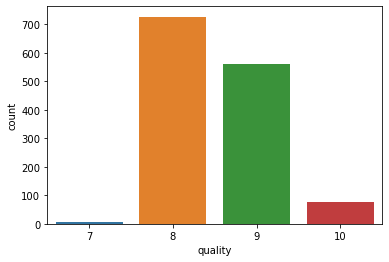

In [38]:
sns.countplot(data=sample_submission, x=TARGET)

In [39]:
all_cv_scores.sort_values(by=["Score"], ascending=False)

,Model,Score,StdDev,RunTime
3,cat1,0.527990,0.015417,84.780946
2,lgbm3,0.515729,0.006609,2.091830
1,lgbm2,0.498681,0.031206,5.252510
4,cat2,0.495879,0.024778,48.447685
5,cat3,0.495794,0.028221,598.596878
0,lgbm1,0.490988,0.018546,118.041078
